<a href="https://colab.research.google.com/github/swarthyPig/Raspberry-Pi_DHT22_Weather_Station_with_correlation-and-ML/blob/master/machine%20learning/Keras_MRL.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Using TensorFlow backend.


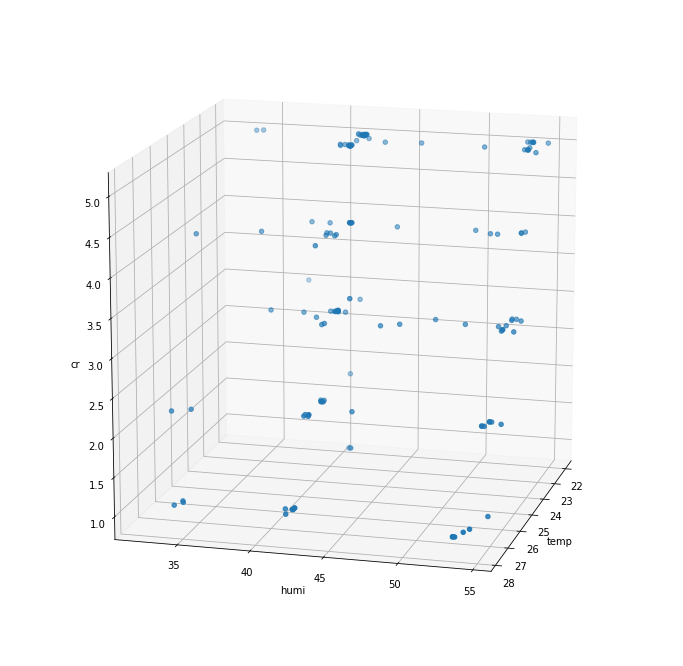

In [1]:
from __future__ import print_function
import numpy as np
import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers.core import Dense
from keras.optimizers import RMSprop

import numpy as np
from pandas.io.parsers import read_csv
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline

data = read_csv('iot_data.csv', sep=',')

data = np.array(data, dtype=np.float32)

xs = np.array(data[:,1], dtype=np.float32)
ys = np.array(data[:,2], dtype=np.float32)
zs = np.array(data[:,-1], dtype=np.float32)

fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(xs, ys, zs)
ax.set_xlabel('temp')
ax.set_ylabel('humi')
ax.set_zlabel('cr')
ax.view_init(15, 15)

plt.show()

In [2]:
# data split
from sklearn.model_selection import train_test_split

x_data = data[0:-50, 1:-1] # temp, humi

y_data = data[0:-50, [-1]] # cr

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, 
                                                    test_size=0.2, random_state=0)

print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(88, 2)
(88, 1)
(23, 2)
(23, 1)


In [4]:
rmsprop = RMSprop(lr=0.01)

model = Sequential()
model.add(Dense(1, input_shape=(2,)))
model.compile(loss='mse', optimizer=rmsprop, metrics=['accuracy'])
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 1)                 3         
Total params: 3
Trainable params: 3
Non-trainable params: 0
_________________________________________________________________


In [5]:
hist = model.fit(x_train, y_train, epochs = 2000)

Instructions for updating:
Use tf.cast instead.
Epoch 1/2000
88/88 [==============================] - 0s 6ms/step - loss: 837.2282 - acc: 0.0000e+00
Epoch 2/2000
88/88 [==============================] - 0s 44us/step - loss: 609.6871 - acc: 0.0000e+00
Epoch 3/2000
88/88 [==============================] - 0s 41us/step - loss: 477.8881 - acc: 0.0000e+00
Epoch 4/2000
88/88 [==============================] - 0s 34us/step - loss: 381.1467 - acc: 0.0000e+00
Epoch 5/2000
88/88 [==============================] - 0s 34us/step - loss: 304.1352 - acc: 0.0000e+00
Epoch 6/2000
88/88 [==============================] - 0s 34us/step - loss: 241.8851 - acc: 0.0000e+00
Epoch 7/2000
88/88 [==============================] - 0s 33us/step - loss: 190.5871 - acc: 0.0000e+00
Epoch 8/2000
88/88 [==============================] - 0s 33us/step - loss: 148.0748 - acc: 0.0000e+00
Epoch 9/2000
88/88 [==============================] - 0s 33us/step - loss: 113.4063 - acc: 0.0000e+00
Epoch 10/2000
88/88 [==============

In [6]:
print('## training loss and acc ##')
print(hist.history['loss'])
print(hist.history['acc'])


## training loss and acc ##
[837.2281549627131, 609.6870949485085, 477.88810313831675, 381.1466979980469, 304.13517345081675, 241.8850860595703, 190.58711797540838, 148.0748256336559, 113.40634710138494, 85.17183962735263, 62.55691771073775, 44.767512581565164, 31.37157578901811, 21.71900766546076, 15.053350535306064, 10.612767046148127, 7.914341579784047, 6.573378259485418, 5.943310824307528, 5.694965015758168, 5.587329561060125, 5.536238757046786, 5.519613396037709, 5.444644451141357, 5.401294578205455, 5.35174018686468, 5.338093367489901, 5.388413515957919, 5.416026592254639, 5.304545055736195, 5.271651744842529, 5.066071466966108, 5.050327647816051, 4.81349329514937, 5.152470198544589, 4.950187162919478, 4.700376033782959, 4.806939406828447, 4.923990726470947, 4.726957819678566, 4.302525390278209, 4.380570151589134, 4.261035247282549, 4.135711366480047, 4.1981469934636895, 4.013924598693848, 3.9318836385553535, 5.13318943977356, 3.8661563396453857, 3.7828048142519863, 3.71988452564

In [7]:
# list all data in history
print(hist.history.keys())

dict_keys(['loss', 'acc'])


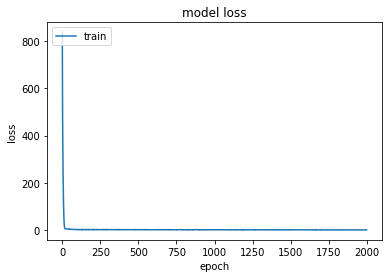

In [8]:
# summarize history for loss
plt.plot(hist.history['loss'])
plt.title('model loss')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [9]:
# model에 임의의 값을 넣어 test
#model.predict(x_train)
model.predict(np.array([23,43]).reshape(1,2))

array([[3.2456264]], dtype=float32)

In [10]:
# 모델평가
test_loss, test_acc = model.evaluate(x_test, y_test)
print('정확도 :', test_acc)

23/23 [==============================] - 0s 668us/step
정확도 : 0.30434781312942505


In [15]:
# get weight, bias value
W_, b_ = model.get_weights()
print(W_)
print('weigth : ', W_[0],W_[1]) 
print('bias : ', b_)

[[-0.30618072]
 [ 0.04344913]]
weigth :  [-0.30618072] [0.04344913]
bias :  [8.41947]


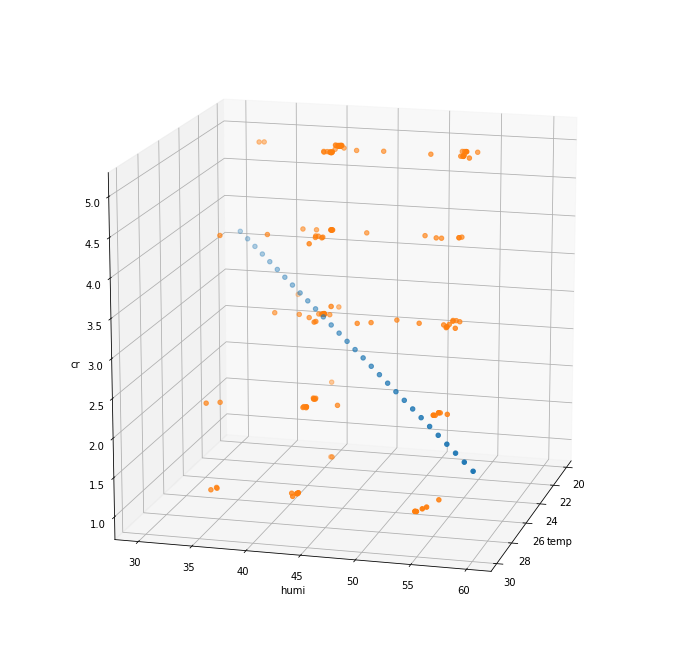

In [12]:
x = np.linspace(20, 30, 30).reshape(30,1) # Temp range(20~30, 간격:30)
y = np.linspace(30, 60, 30).reshape(30,1) # Humi range(30~60, 간격:30)

X = np.concatenate((x,y), axis=1)
Z = np.matmul(X, W_) + b_

fig = plt.figure(figsize=(12,12))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, Z)
ax.scatter(xs, ys, zs)
ax.set_xlabel('temp')
ax.set_ylabel('humi')
ax.set_zlabel('cr')
ax.view_init(15, 15)

plt.show()